# Numerische Simulation des Dreikörperproblems
Dieses Notebook ist eine Beilage zur Facharbeit: *Präzision von numerischen 3-Körper-Simulationen*  
---
Um die Präzision zu vergleichen, lassen sich die Verfahren in folgenden Parameter vergleichen:
*   Energieerhaltung
*   Impulserhaltung
*   Zeitreversibilität  
*   Divergenz von *gestörten* Systemen
---
Zudem wird die Schrittgröße-Entwicklung im Bulirsch-Stoer-Verfahren analysiert, das Chaos untersucht und eine Strom-Darstellung der Beschleunigung vollzogen.



In [ ]:
# Importieren von Bibliotheken
import matplotlib.pyplot as plt                     # Darstellen von Plots
from matplotlib import rcParams                     # Verändern der Größe der Plot-Darstellungen
from matplotlib.colors import BASE_COLORS as colors # Nutzen der verschiedenen Basis-Farben
%matplotlib inline   
from mpmath import *                                # Hoch-Präzisions-Arithmetik
import numpy as np                                  # Nutzen von speziellen Arrays     

## Implementierung verschiedener Verfahren

### Euler-Verfahren

$$\vec{r}_{i+1} = \vec{r}_i + h\dot{\vec{r}}_i$$
$$\dot{\vec{r}}_{i+1} = \dot{\vec{r}}_i + h\ddot{\vec{r}}(\vec{r}_i)$$

In [ ]:
# EULER VERFAHREN
def eulerMethod(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]] 
  # Liste an Zeiten (zugehörig zu den simulierten Werten)
  times = []
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hinzufügen der neuen Zeit
    times.append(t)
    # Iteration über alle Körper
    for i in range(3): 
      # Berechnen der neuen Position auf Basis des vorherigen Zeitschrittes
      positions[i].append(positions[i][n]+velocities[i][n] * h) 
      # Berechnen der Beschleunigung auf Körper i mit den Positionen des letzten Zeitschrittes
      acceleration = a(positions[i][n],masses[i],positions[(i+1)%3][n],masses[(i+1)%3],positions[(i+2)%3][n],masses[(i+2)%3])
      # Berechnen der neuen Geschwindigkeit auf Basis des vorherigen Zeitschrittes
      velocities[i].append(velocities[i][n] + acceleration * h)
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  
  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"Euler"


### Euler-Cromer-Verfahren
$$\dot{\vec{r}}_{i+1} = \dot{\vec{r}}_i + h\ddot{\vec{r}}(\vec{r}_{i})$$
$$\vec{r}_{i+1} = \vec{r}_i + h\dot{\vec{r}}_{i+1}$$

In [ ]:
# EULER-CROMER VERFAHREN
def eulerCromerVelocityMethod(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]] 
  # Liste an Zeiten (zugehörig zu den simulierten Werten)
  times = []
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hinzufügen der neuen Zeit
    times.append(t)
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Beschleunigung auf Körper i mit den Positionen des letzten Zeitschrittes
      acceleration = a(positions[i][n],masses[i],positions[(i+1)%3][n],masses[(i+1)%3],positions[(i+2)%3][n],masses[(i+2)%3])
      # Berechnen der neuen Geschwindigkeit auf Basis des vorherigen Zeitschrittes
      velocities[i].append(velocities[i][n] + acceleration * h)
      # Berechnen der neuen Position auf Basis des vorherigen Zeitschrittes mit den Geschwindigkeiten des aktuellen Zeitschrittes
      positions[i].append(positions[i][n]+velocities[i][n+1] * h)
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  
  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"Euler-Cromer-Geschwindigkeit"

$$\vec{r}_{i+1} = \vec{r}_i + h\dot{\vec{r}}_{i}$$
$$\dot{\vec{r}}_{i+1} = \dot{\vec{r}}_i + h\ddot{\vec{r}}(\vec{r}_{i+1})$$

In [ ]:
# EULER-CROMER VERFAHREN
def eulerCromerPositionMethod(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]] 
  # Liste an Zeiten (zugehörig zu den simulierten Werten)
  times = []
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hinzufügen der neuen Zeit
    times.append(t)
    # Zunächst werden die Positionen der drei Körper aktualisiert
    for i in range(3):
      # Berechnen der neuen Position auf Basis des vorherigen Zeitschrittes mit den Geschwindigkeiten des aktuellen Zeitschrittes
      positions[i].append(positions[i][n]+velocities[i][n] * h)
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Beschleunigung auf Körper i mit den Positionen des aktuellen Zeitschrittes
      acceleration = a(positions[i][n+1],masses[i],positions[(i+1)%3][n+1],masses[(i+1)%3],positions[(i+2)%3][n+1],masses[(i+2)%3])
      # Berechnen der neuen Geschwindigkeit auf Basis des aktuellen Zeitschrittes
      velocities[i].append(velocities[i][n] + acceleration * h)
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  

  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"Euler-Cromer-Position"

### Heun-Verfahren
$$\dot{\vec{r}}_{i+1} = \dot{\vec{r}}_i + h\ddot{\vec{r}}(\vec{r}_i)$$
$$\vec{r}_{i+1} = \vec{r}_i + \frac{h}{2} (\dot{\vec{r}}_{i}+\dot{\vec{r}}_{i+1})$$

In [ ]:
# HEUN VERFAHREN
def heunMethod(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]] 
  # Liste an Zeiten (zugehörig zu den simulierten Werten)
  times = []
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hinzufügen der neuen Zeit
    times.append(t)
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Beschleunigung auf Körper i mit den Positionen des letzten Zeitschrittes
      acceleration = a(positions[i][n],masses[i],positions[(i+1)%3][n],masses[(i+1)%3],positions[(i+2)%3][n],masses[(i+2)%3])
      # Berechnen der neuen Geschwindigkeit auf Basis des vorherigen Zeitschrittes
      velocities[i].append(velocities[i][n] + acceleration * h)
      # Berechnen der neuen Position auf Basis des vorherigen Zeitschrittes 
      # mit dem arithm. Mittelwert, der Geschwindigkeiten des vorherigen und des aktuellen Zeitschrittes
      positions[i].append(positions[i][n]+(velocities[i][n+1]+velocities[i][n]) * h/2)
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  
  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"Heun"

### Leapfrog-Standard-Verfahren
$$\dot{\vec{r}}_{\frac{1}{2}} = \dot{\vec{r}}_0 + \frac{h}{2}\ddot{\vec{r}}(\vec{r}_0)$$
$$\vec{r}_{i+1} = \vec{r}_i + h\dot{\vec{r}}_{i+\frac{1}{2}}$$
$$\dot{\vec{r}}_{i+\frac{3}{2}} = \dot{\vec{r}}_{i+\frac{1}{2}} + h\ddot{\vec{r}}(\vec{r}_{i+1})$$

In [ ]:
# LF-STANDARD-VERFAHREN
def lfDefaultMethod(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]] 
  # Liste an Zeiten (zugehörig zu den simulierten Positionen)
  times = []
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Pre-Iteration (um den Versatz von 1/2 zu erzeugen)
  for i in range(3):
    # Berechnen der Beschleunigung auf Körper i mit den Startpositionen
    acceleration = a(positions[i][n],masses[i],positions[(i+1)%3][n],masses[(i+1)%3],positions[(i+2)%3][n],masses[(i+2)%3])
    # Berechnen der Geschwindigkeiten nach einem halben Schritt
    velocities[i][0] = velocities[i][0] + h/2 * acceleration
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hinzufügen der neuen Zeit
    times.append(t)
    # Hierbei muss zuerst die Position aller Körper errechnet werden, 
    # bevor die Geschwindigkeiten berechntet werden, da die Beschleunigungen von den Positionen abhängen
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Position auf Basis des vorherigen Zeitschrittes und der versetzten Geschwindigkeit
      positions[i].append(positions[i][n]+velocities[i][n] * h)
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Beschleunigung auf Körper i mit den Positionen des aktuellen Zeitschrittes
      acceleration = a(positions[i][n+1],masses[i],positions[(i+1)%3][n+1],masses[(i+1)%3],positions[(i+2)%3][n+1],masses[(i+2)%3])
      # Berechnen der neuen versetzten Geschwindigkeit
      velocities[i].append(velocities[i][n] + acceleration * h) 
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  
  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"Leapfrog"

### Original-Verlet-(Störmer)-Verfahren
$$\vec{r}_{i+1} = -\vec{r}_{i-1} + 2 \vec{r}_{i} + h^2\ddot{\vec{r}}(\vec{r}_i)$$
$$\dot{\vec{r}}_{i} = \frac{\vec{r}_{i+1} - \vec{r}_{i-1}}{2h}$$

In [ ]:
# ORIGINAL-VERLET-STÖRMER-VERFAHREN
def verletStörmerMethod(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]] 
  # Liste an Zeiten (zugehörig zu den simulierten Werten)
  times = []
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Pre-Iteration (um Berechnung mit r_i-1 zu ermöglichen)

  times.append(t)
  for i in range(3):
    # Berechnen der Positionen nach Euler
    positions[i].append(positions[i][0] + h*velocities[i][0])
    # Berechnen der Geschwindigkeiten
    velocities[i].append((positions[i][1]-positions[i][0])/(2*h))
  t+= h
  # Anzahl der Schritte muss erhöht werden
  n+=1
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hinzufügen der neuen Zeit
    times.append(t)
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Beschleunigung auf Körper i mit den Positionen des aktuellen Zeitschrittes
      acceleration = a(positions[i][n],masses[i],positions[(i+1)%3][n],masses[(i+1)%3],positions[(i+2)%3][n],masses[(i+2)%3])
      # Berechnen der Position gemäß dem Verlet-Verfahren
      positions[i].append(2*positions[i][n]-positions[i][n-1]+h*h*acceleration)
      # Berechnen der neuen Geschwindigkeit auf Basis der Positionen
      velocities[i].append((positions[i][n+1]-positions[i][n-1])/(2*h)) 
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  
  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"Verlet-Störmer"

In [ ]:
# ORIGINAL-VERLET-STÖRMER-VERFAHREN
def verletStörmerVariantMethod(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]] 
  # Liste an Zeiten (zugehörig zu den simulierten Werten)
  times = []
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Pre-Iteration (um Berechnung mit r_i-1 zu ermöglichen)

  times.append(t)
  for i in range(3):
    # Berechnen der Positionen nach Euler
    positions[i].append(positions[i][0] + h*velocities[i][0])
    # Berechnen der Geschwindigkeiten
    velocities[i].append((positions[i][1]-positions[i][0])/(2*h))
  t+= h
  # Anzahl der Schritte muss erhöht werden
  n+=1
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hinzufügen der neuen Zeit
    times.append(t)
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Beschleunigung auf Körper i mit den Positionen des aktuellen Zeitschrittes
      acceleration = a(positions[i][n],masses[i],positions[(i+1)%3][n],masses[(i+1)%3],positions[(i+2)%3][n],masses[(i+2)%3])
      # Berechnen der Position gemäß dem Verlet-Verfahren
      positions[i].append(2*positions[i][n]-positions[i][n-1]+h*h*acceleration)
      # Berechnen der neuen Geschwindigkeit auf Basis der Positionen
      velocities[i].append((positions[i][n+1]-positions[i][n])/h) 
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  
  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"Verlet-Störmer-Variante"

### Geschwindigkeit-Verlet-Verfahren
$$\dot{\vec{r}}_{i} = \dot{\vec{r}}_{i-\frac{1}{2}} + \frac{h}{2} \ddot{\vec{r}}(\vec{r}_i)$$ 
$$\dot{\vec{r}}_{i+\frac{1}{2}} = \dot{\vec{r}}_i + \frac{h}{2} \ddot{\vec{r}}(\vec{r}_i)$$ 
$$\vec{r}_{i+1} = \vec{r}_{i} + h \dot{\vec{r}}_{i+\frac{1}{2}}$$

In [ ]:
# GESCHWINDIGKEIT-VERLET-VERFAHREN
def velocityVerletMethod(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]]
  # Liste der aktuellen Beschleunigungen
  # (Speicherung ist aufgrund der Geschwindigkeitsberechnung nötig) 
  accelerations = []
  # Liste an Zeiten (zugehörig zu den simulierten Werten)
  times = []
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Berechnen der Anfangsbeschleunigungen
  for i in range(3):
    acceleration = a(positions[i][n],masses[i],positions[(i+1)%3][n],masses[(i+1)%3],positions[(i+2)%3][n],masses[(i+2)%3])
    accelerations.append(acceleration)
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hinzufügen der neuen Zeit
    times.append(t)
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Halbschritt Geschwindigkeit
      velocities[i].append(velocities[i][n] + h*accelerations[i]/2) 
      # Berechnen der Position gemäß dem Geschwindigkeit-Verlet-Verfahren
      positions[i].append(positions[i][n] + h*velocities[i][n+1])
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der neuen Beschleunigung
      accelerations[i] = a(positions[i][n+1],masses[i],positions[(i+1)%3][n+1],masses[(i+1)%3],positions[(i+2)%3][n+1],masses[(i+2)%3])
      # Überschreiben der Halbschritt Geschwindigkeit mit der Ganzschritt Geschwindigkeit
      velocities[i][n+1] = velocities[i][n+1] + h*accelerations[i]/2
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  
  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"Geschwindigkeit-Verlet"

### Runge-Kutta 4er Ordnung
$$K_{v1} = h\ddot{\vec{r}}(\vec{r}_i)$$
$$K_{r1} = h\dot{\vec{r}}_i$$
$$K_{v2} = h\ddot{\vec{r}}(\vec{r}_i+\frac{K_{r1}}{2})$$
$$K_{r2} = h(\dot{\vec{r}}_i+\frac{K_{v1}}{2})$$
$$K_{v3} = h\ddot{\vec{r}}(\vec{r}_i+\frac{K_{r2}}{2})$$
$$K_{r3} = h(\dot{\vec{r}}_i+\frac{K_{v2}}{2})$$
$$K_{v4} = h\ddot{\vec{r}}(\vec{r}_i+K_{r3})$$
$$K_{r4} = h(\dot{\vec{r}}_i+K_{v3})$$

In [ ]:
# 4er-ORDNUNG-RUNGE-KUTTA-VERFAHREN
def rk4Method(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]] 
  # Liste an Zeiten (zugehörig zu den simulierten Werten)
  times = []
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hinzufügen der neuen Zeit
    times.append(t)
    # Liste an Runge-Kutta-Termen
    kv = [[] for i in range(4)]
    kr = [[] for i in range(4)]
    # Berechnen der Runge-Kutta-Terme
    for i in range(3):
      kv[0].append(h*a(positions[i][n],masses[i],positions[(i+1)%3][n],masses[(i+1)%3],positions[(i+2)%3][n],masses[(i+2)%3]))
      kr[0].append(velocities[i][n] * h)
    for i in range(3):
      kv[1].append(h*a(positions[i][n]+kr[0][i]/2,masses[i],positions[(i+1)%3][n]+kr[0][(i+1)%3]/2,masses[(i+1)%3],positions[(i+2)%3][n]+kr[0][(i+2)%3]/2,masses[(i+2)%3]))
      kr[1].append((velocities[i][n]+kv[0][i]/2) * h)
    for i in range(3):
      kv[2].append(h*a(positions[i][n]+kr[1][i]/2,masses[i],positions[(i+1)%3][n]+kr[1][(i+1)%3]/2,masses[(i+1)%3],positions[(i+2)%3][n]+kr[1][(i+2)%3]/2,masses[(i+2)%3]))
      kr[2].append((velocities[i][n]+kv[1][i]/2) * h)
    for i in range(3):
      kv[3].append(h*a(positions[i][n]+kr[2][i],masses[i],positions[(i+1)%3][n]+kr[2][(i+1)%3],masses[(i+1)%3],positions[(i+2)%3][n]+kr[2][(i+2)%3],masses[(i+2)%3]))
      kr[3].append((velocities[i][n]+kv[2][i]) * h)
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der neuen Geschwindigkeit auf Basis des vorherigen Zeitschrittes
      velocities[i].append(velocities[i][n] + (kv[0][i]+2*kv[1][i]+2*kv[2][i]+kv[3][i])/6)
      # Berechnen der neuen Position auf Basis des vorherigen Zeitschrittes 
      positions[i].append(positions[i][n]+(kr[0][i]+2*kr[1][i]+2*kr[2][i]+kr[3][i])/6)
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  # Hinzufügen der letzten Zeit
  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"RK4"

### Bulirsch-Stoer-Verfahren

In [ ]:
# Extrapolation (NEVILLE'S ALGORITHM)
# T := Tableau, 
def neville(T,stepsSeq,k):
  # Tableau Struktur
  #   0 1 2 3 4 j
  # 0 T
  # 1 T T
  # 2 T T T
  # 3 T T T T
  # 4 T T T T T
  #k-1
  # Verhindern von Mutation der Liste (kopieren)
  tab = T.copy()
  # Iteration über alle bisherigen Simulationsergebnisse des aktuellen Zeitschrittes
  for j in range(1,k): 
    # Berechnen der neuen Spalte gemäß des Neville-Alg
    tkjNew = tab[k-1][j-1] + (tab[k-1][j-1]-tab[k-2][j-1])/((stepsSeq[k-1]/stepsSeq[k-j-1])**2 - 1)
    # Hinzufügen der neuen Spalte
    tab[k-1].append(tkjNew)
  # Berechnen des Fehlers (normalisieren mit 12 [Anzahl der Dimensionen])
  error = np.linalg.norm(tab[k-1][k-1] - tab[k-1][k-2])/12
  # Zurückegeben des Fehlers und des neuen Tableaus
  return error,tab

# Funktion zur Konsolen-Ausgabe eines Tableaus [UNWICHTIG]
def printTab(tab):
  for i in range(len(tab)):
    print(tab[i])

# Optimiertes Leapfrog-Verfahren (überflüssige Zwischenspeicherung der Positionen wird vermieden)
def optimizedLF(a, startPositions, startVelocities, masses, h, T):
  # Liste der Positionen (Form := [3,3])
  positions = [startPositions[0],startPositions[1],startPositions[2]] 
  # Liste der Geschwindigkeiten (Form := [3,3])
  velocities = [startVelocities[0],startVelocities[1],startVelocities[2]] 
  # Anzahl getätigter Schritte
  n = 0 
  # Aktuelle Zeit
  t = 0
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Hierbei muss zuerst die Position aller Körper errechnet werden, 
    # bevor die Geschwindigkeiten berechntet werden, da die Beschleunigungen von den Positionen abhängen
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Position auf Basis der versetzten Geschwindigkeit
      positions[i] += velocities[i] * h
    # Iteration über alle Körper
    for i in range(3):
      # Berechnen der Beschleunigung auf Körper i
      acceleration = a(positions[i],masses[i],positions[(i+1)%3],masses[(i+1)%3],positions[(i+2)%3],masses[(i+2)%3])
      # Berechnen der neuen versetzten Geschwindigkeit
      velocities[i] += acceleration * h
    # Erhöhung des Schrittzählers
    n += 1
    # Erhöhung der Zeit
    t += h
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return positions,velocities

In [ ]:
# BULIRSCH-STOER-VERFAHREN
def bulirschStoer(a, startPositions, startVelocities, masses, h, T, tol = 1e-4):
  # Liste der Positionen (Form := [3,<Anzahl Schritte>,3])
  positions = [[startPositions[0]],[startPositions[1]],[startPositions[2]]] 
  # Liste der Geschwindigkeiten (Form := [3,<Anzahl Schritte>,3])
  velocities = [[startVelocities[0]],[startVelocities[1]],[startVelocities[2]]]
  # Pre-Iteration (um den Versatz von 1/2 zu erzeugen)
  for i in range(3):
    # Berechnen der Beschleunigung auf Körper i mit den Startpositionen
    acceleration = a(positions[i][0],masses[i],positions[(i+1)%3][0],masses[(i+1)%3],positions[(i+2)%3][0],masses[(i+2)%3])
    # Berechnen der Geschwindigkeiten nach einem halben Schritt
    velocities[i][0] += h/2 * acceleration
  # Liste der Zeiten 
  times = []
  # Aktuelle Zeit
  t = 0
  # Maximaler Wert für die Unterteilung
  kmax = 8
  # Temporäre Schrittgröße => h wird bei Adaption von hTemp benötigt
  hTemp = h
  # Iteration bis Endzeit erreicht ist
  while t <= T: 
    # Definieren eines leeren Tableaus
    tableau = [[0] for _ in range(kmax)]
    # Iteration über alle Werte für die Unterteilungen 
    for k in range(1,kmax+1):
      # Integration des Zeitschrittes mit k-Subschritten mit dem optimierten Leapfrog-Verfahren
      intstep = optimizedLF(a,np.array(positions)[:,-1],np.array(velocities)[:,-1],masses,hTemp/(2*k),hTemp)
      # Aktualisieren der Werte im Tableau (0-basiert => k-1)
      tableau[k-1][0] = np.array([intstep[0],intstep[1]])
      # Wenn k == 1, soll noch keine Extratpolation durchgeführt werden
      if k == 1:
        continue
      # Extratpolation des Tableaus
      error,tableau = neville(tableau,[2*i for i in range(1,kmax+1)],k)
      # Überprüfung des Fehlers (Toleranzprüfung)
      if error <= tol:
        # DEBUG
        if len(times) % 100 == 0:
          print("SUCCESS:",error, "with n =",2*k, "at", t)
        # Erhöhung der Zeit
        t += hTemp
        # Adaptieren der Schrittgröße (Verdopplung bzw. Startschrittgröße)
        hTemp = min(2*hTemp,h)
        # Hinzufügen des neuen Zeitschrittes
        times.append(t)
        # Hinzufügen der extrapolierten Werte zu den BS-Integrationsergebnissen
        for i in range(3):
          positions[i].append(tableau[k-1][k-1][0][i])
          velocities[i].append(tableau[k-1][k-1][1][i])
        # Verlassen der Schleife (Keine weitere Unterteilung nötig)
        break
      else:
        # Fehler nicht klein genug
        pass
        #print("NOT YET:",error, "with n =",2*k)
    else:
      # DEBUG
      if len(times) %100 == 0:
        print("no convergence => h/2",t,hTemp)
      # Die Schleife wurde nicht verlassen => Toleranz wurde nicht unterschritten
      hTemp /= 2
  # Hinzufügen der letzten Zeit
  times.append(t)
  # Rückgabe der berechneten Positionen, Geschwindigkeiten und der Indentifikation
  return times,positions,velocities,"Bulirsch-Stoer"

## Simulation

### Simulationseinstellungen

In [ ]:
mp.dps = 40 # Anzahl der Nachkommastellen (Rundungsfehler)
h = 1e-4   # Schrittgröße (Diskretisierungsfehler)
T = 10  # Endpunkt der Simulation

### Startbedingungen

In [ ]:
# Gravitationskonstante
G = 1.0
# Berechnung der Beschleunigung auf einen Körper 
# (Beschleunigung auf Körper 1 für zurückgegeben) somit ist entscheidend, in welcher Reihenfolge die Werte übergeben werden
a = lambda x1,m1,x2,m2,x3,m3 : G * ((m2*(x2-x1)/np.linalg.norm(x2 - x1)**3)+(m3*(x3-x1)/np.linalg.norm(x3 - x1)**3))
# MASSEN
masses = np.array([3,4,5])
# STARTPOSITIONEN
startPositions = [np.array([mpf(1), mpf(3)]), np.array([mpf(-2), mpf(-1)]), np.array([mpf(1),mpf(-1)])] 
# STARTGESCHWINDIGKEITEN
startVelocities = [np.array([mpf(0), mpf(0)]), np.array([mpf(0), mp.mpf(0)]),np.array([mpf(0), mpf(0)])]

### Ausführen der Simulationen

In [ ]:
# Liste der Verfahren für die Simulation
# 1 eulerMethod
# 2 eulerCromerVelocityMethod
# 3 eulerCromerPositionMethod
# 4 heunMethod
# 5 lfDefaultMethod
# 6 verletStörmerMethod
# 7 velocityVerletMethod
# 8 rk4Method
# 9 bulirschStoerMethod
simulations = [#eulerMethod,
               #eulerCromerVelocityMethod,
               #eulerCromerPositionMethod,
               #heunMethod,
               lfDefaultMethod,
               #verletStörmerMethod,
               #velocityVerletMethod,
               #rk4Method,
              ]
# Liste der Ergebnisse der Verfahren für jedes Integrations-Verfahren: 
# [[<Zeiten>,<Positionen>,<Geschwindigkeiten>,<Identifikation>],...]
results = []
# Simulationsfunktion für jedes Verfahren wird ausgeführt
for simulation in simulations:
  results.append(list(simulation(a,startPositions,startVelocities,masses,h,T)))

NameError: ignored

In [ ]:
# Bulirsch-Stoer-Verfahren wird genutzt (andere Parameter)
results.append(bulirschStoer(a,startPositions,startVelocities,masses,1e-3,T,tol = 1e-5))

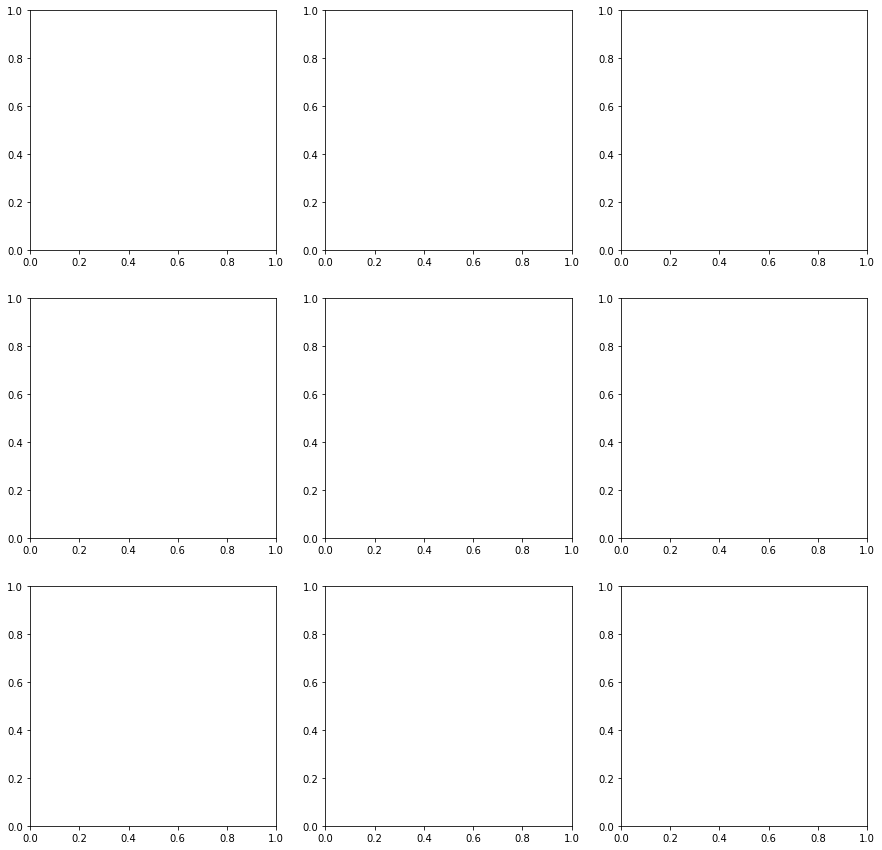

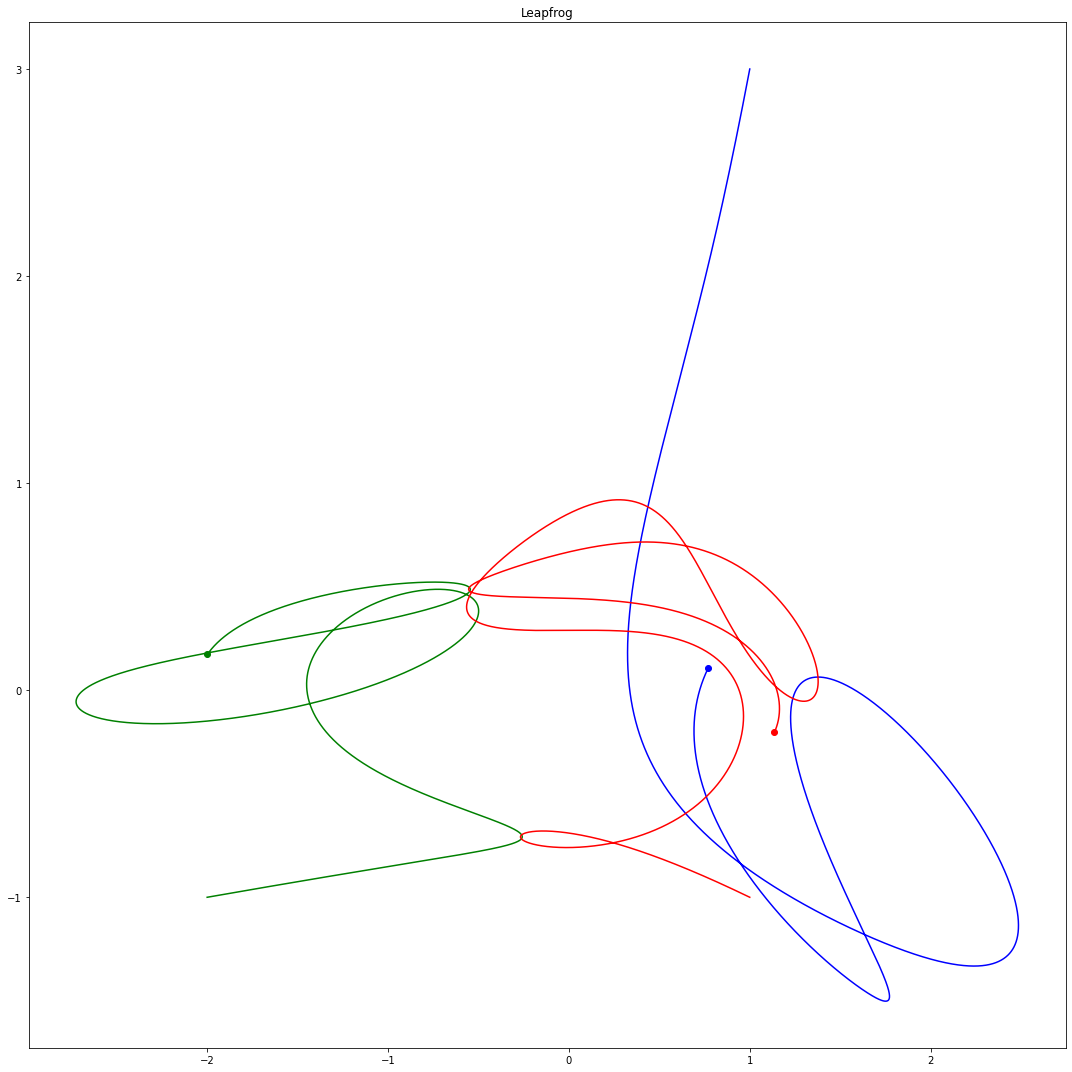

In [ ]:
# Ändern der Größe der Abbildung
plt.rcParams["figure.figsize"] = (8,8)
# Erstellen eines Plots
if len(simulations) == 1:
  fig, ax = plt.subplots()
else:
  fig, ax = plt.subplots(3,3)
# Iteration über alle Ergebnisse
for i in range(len(results)):
  # Iteration über alle Körper (Flugbahn jedes Körpers muss eingezeichnet werden)
  for j in range(3):

      # Plotten aller Positionen
      if len(simulations) == 1:
        ax.plot(np.array(results[i][1][j])[:,0], np.array(results[i][1][j])[:,1], color=list(colors)[j])
        ax.scatter(np.array(results[i][1][j])[-1,0], np.array(results[i][1][j])[-1,1], color=list(colors)[j])
      else:
        ax[i//3][i%3].plot(np.array(results[i][1][j])[:,0], np.array(results[i][1][j])[:,1], color=list(colors)[j]) 
        # Plotten der letzten Position
        ax[i//3][i%3].scatter(np.array(results[i][1][j])[-1,0], np.array(results[i][1][j])[-1,1], color=list(colors)[j])
  # Setzen des Titels des Plots
  if len(simulations) == 1:
    ax.set_title(results[i][3])
  else:
    ax[i//3][i%3].set_title(results[i][3])
  fig.tight_layout()
# Anzeigen des Plots
plt.show()
# Speichern der Grafik (.pdf)
fig.savefig('trajectories.pdf')

Ergebnisse:  
<img src="https://drive.google.com/uc?export=view&id=1mxPff7kho1r1GDoaFcSagdSWZCU_JAi3" width="400"/>

### Impulserhaltung
$$ \sum_{i=0}^3 m_i \cdot \dot{\vec{r}}_i = const$$

In [ ]:
# Berechnen des Anfangsimpulses (Summe aller Impulse)
initialMomentum = sum([masses[body] * startVelocities[body] for body in range(3)])
# Liste der Impulsabweichungen
momentumErrors = []
# Berechnen der Abweichung für jedes Simulationsverfahren bei jedem Zeitschritt
for i in range(len(results)):
  # Liste der Abweichungen für jeden Zeitschritt
  derivation = []
  # Iteration über alle Zeitschritte
  for n in range(len(results[i][1][0])):
    # Berechnen des Gesamtimpulses
    momentum = sum([masses[body] * results[i][2][body][n] for body in range(3)])
    # Berechnen der Differenz zum Anfangsimpuls (Betrag des Vektors)
    derivation.append(np.linalg.norm(momentum-initialMomentum))
  # Hizufügen aller Impulsabweichungen dieses Verfahrens (mit den zugehörigen Zeiten)
  momentumErrors.append([results[i][0],derivation,results[i][3]])

In [ ]:
# Ändern der Größe der Abbildung
plt.rcParams["figure.figsize"] = (10,10)
# Erstellen eines Plots
fig = plt.figure()
ax = fig.add_subplot()
# Verschiedene Linien Arten (für bessere Visibilität)
lines = [(0, (1, 0.5)),"--"]
# Iteration über die Imupulsabweichungen
for error in range(len(momentumErrors)):
  # Darsetllen der Impulsabweichung
  ax.plot(momentumErrors[error][0],momentumErrors[error][1],label=momentumErrors[error][2],ls=lines[error % len(lines)])
# Ändern der Skalierung (auf logarithmisch)
ax.set_yscale('log')
# Beschriften der Achsen
ax.set_ylabel('$err_{abs}$')
ax.set_xlabel('T (Zeiteinheiten)')
# Ändern der Position der Legende
ax.legend(loc="upper left")
# Anzeigen des Plots
plt.show()
# Speichern der Grafik (.pdf)
fig.savefig('momentum.pdf')

Ergebnisse:  
<img src="https://drive.google.com/uc?export=view&id=1Q-uWvUKNgaVnWbV3gZ7TVZ0EItzSPH9p" width="400"/>

### Energieerhaltung
$$\sum_{i=1}^3 \frac{p_{i}^2}{2m_i} - \gamma \sum_{i=1}^3 \sum_{j=i+1}^3 \frac{m_i\cdot m_j}{|\vec{r}_{i}-\vec{r}_{j}|} = const$$

In [ ]:
# Berechnen der kinetischen Energie
initialKin = 0.5 * np.linalg.norm(sum([masses[body] * startVelocities[body]**2 for body in range(3)]))
# Berechnen der potentiellen Energie
initialPot = -G* np.linalg.norm(sum([sum([(masses[bodyi]*masses[bodyj]/(np.linalg.norm(startPositions[bodyi]-startPositions[bodyj]))) for bodyj in range(bodyi+1,3)])for bodyi in range(3)]))
# Berechnen der Gesamtenergie
initialEnergy = initialKin+initialPot
# Liste an Abweichungen
energyErrors = []
# Berechnen der Abweichung für jedes Simulationsverfahren bei jedem Zeitschritt
for i in range(len(results)):
  # Liste der Abweichungen für jeden Zeitschritt
  derivation = []
  # Iteration über alle Zeitschritte
  for n in range(len(results[i][1][0])):
    # Berechnen der kinetischen Energie
    kin = 0.5 * np.linalg.norm(sum([masses[body] * results[i][2][body][n]**2 for body in range(3)]))
    # Berechnen der potentiellen Energie
    pot = -G* np.linalg.norm(sum([sum([(masses[bodyi]*masses[bodyj]/(np.linalg.norm(results[i][1][bodyi][n]-results[i][1][bodyj][n]))) for bodyj in range(bodyi+1,3)])for bodyi in range(3)]))
    # Berechnen der relativen Abweichung zur Anfangsenergie
    derivation.append(abs(((kin+pot)-initialEnergy)/initialEnergy))
  # Hinzufügen des Fehlers des Verfahrens
  energyErrors.append([results[i][0],derivation,results[i][3]])

In [ ]:
# Ändern der Größe der Abbildung
plt.rcParams["figure.figsize"] = (10,10)
# Erstellen eines Plots
fig = plt.figure()
ax = fig.add_subplot()
# Verschiedene Linien Arten (für bessere Visibilität)
lines = [(0, (1, 0.5)),"--"]
# Iteration über alle Energieabweichungen
for error in range(len(energyErrors)):
  # Darstellen der Energieabweichung
  ax.plot(energyErrors[error][0],energyErrors[error][1],label=energyErrors[error][2],ls=lines[error % len(lines)])
# Ändern der Skala (logarithmisch)
ax.set_yscale('log')
# Beschriften der Achsen
ax.set_ylabel('$\Delta H_{rel}$', fontsize = 14)
ax.set_xlabel('T (Zeiteinheiten)')
# Ändern der Position der Legende
ax.legend(loc="upper left")
# Anzeigen des Plots
plt.show()
# Speicher der Grafik (.pdf)
fig.savefig('energy.pdf')

Ergebnisse:  
<img src="https://drive.google.com/uc?export=view&id=1f5R-ZWj0eLhylLPK0UCZntqEo2phyruh" width="400"/>

### Exponentielle Instabilität
Hierbei soll ein System leicht verändert werden und die Abweichung über Zeit zum *Pythagoreischen Dreikörperproblem* gemessen werden.
Die Veränderung trifft hierbei die Position eines Körpers (Verschiebung um $+0.01$ in x-Richtung). 

In [ ]:
# MASSEN
masses = np.array([3,4,5])
# STARTPOSITIONEN (gestört)
startPositions2 = [np.array([mpf(1.01), mpf(3)]), np.array([mpf(-2), mpf(-1)]), np.array([mpf(1),mpf(-1)])] 
# STARTGESCHWINDIGKEITEN
startVelocities = [np.array([mpf(0), mpf(0)]), np.array([mpf(0), mp.mpf(0)]),np.array([mpf(0), mpf(0)])]

In [ ]:
# Ergebnisse der Simulaitonen der gestörten Systeme
expInsResults = []
for sim in simulations:
  # Ausführen der Simulationsfunktion aller Verfahren
  expInsResults.append(list(sim(a,startPositions2,startVelocities,masses,h,T)))

In [ ]:
# Liste der Abweichung für alle Verfahren
deltaDiff = []
# Iteration über alle Simulationsergebnisse der gestörten Verfahren
for res in range(len(expInsResults)):
  # Abweichung für alle Zeitschritte
  deltas = []
  # Iteration über alle Zeitschritte
  for n in range(len(expInsResults[res][0])):
    # Berechnen der Phasenraumdifferenz des gestörten Systems und des PDKP bei Zeitschritt n
    delta = sum([sum([abs(results[res][1][i][n][j]-expInsResults[res][1][i][n][j])+abs(results[res][2][i][n][j]-expInsResults[res][2][i][n][j]) for j in range(2) ] ) for i in range(3)])/12 # 12 wegen 2d
    # Hinzufügen der berechneten Abweichung
    deltas.append(delta)
  # Hinzufügen der berechneten Abweichungen 
  deltaDiff.append([expInsResults[res][0],deltas,expInsResults[res][3]])

In [ ]:
# Ändern der Größe der Abbildung
plt.rcParams["figure.figsize"] = (10,10)
# Erstellen eines Plots
fig = plt.figure()
ax = fig.add_subplot()
# Verschiedene Linien Arten (für bessere Visibilität)
lines = [(0, (1, 0.5)),"--"]
# Iteration über die berechneten Abweichungen jedes Verfahrens
for diff in range(len(deltaDiff)):
  # Darstellen der Abweichungen in Abhängigkeit der Zeit
  ax.plot(deltaDiff[diff][0],deltaDiff[diff][1],label=deltaDiff[diff][2],ls=lines[diff % len(lines)])
# Ändern der Skala (logarithmisch)
ax.set_yscale('log')
# Beschriften der Achsen
ax.set_ylabel('$\delta$', fontsize=14)
ax.set_xlabel('T (Zeiteinheiten)')
# Ändern der Position der Legende
ax.legend(loc="upper left")
# Anzeigen des Plots
plt.show()
# Speichern der Grafik (.pdf)
fig.savefig('expIns.pdf')

Ergebnisse:  
<img src="https://drive.google.com/uc?export=view&id=1NyHUUyvwHoBN-0dkuMrA2RWgi7nx4603" width="400"/>

### Zeit-Reversibilität
Zum Endzeitpunkt, werden die Geschwindigkeiten negiert und eine neue Simulationen mit den Endpositionen als Startpositionen wird gestartet. Die Abweichung, die hierbei von den Positionen der ersten Simulation entsteht, kann als Fehler angesehen werden.

In [ ]:
# Ergebnisse der reverse-sim
reversedResults = []
# Iteration über alle Simulationen
for i in range(len(simulations)):
  # Simulation mit negierter Geschwindigkeit und den Endpositionen wird gestartet
  reversedSim = list(simulations[i](a,np.array(results[i][1])[:,-1],-1*np.array(results[i][2])[:,-1],masses,h,T))
  # Umdrehen der Geschwindigkeits und der Positionsergebnisse
  for j in range(3):
    reversedSim[1][j].reverse()
    reversedSim[2][j].reverse()
  # Hinzufügen der Ergebnisse
  reversedResults.append(reversedSim)

In [ ]:
# Liste der Abweichungen aller Verfahren
deltaReversed = []
# Ausrechnen der Abweichungen zwischen den Positionen und Geschwindigkeiten für alle Verfahren
for i in range(len(reversedResults)):
  # Liste der Abweichung für jeden Zeitschritt
  differences = []
  # Iteration über alle Zeitschritte
  for n in range(len(reversedResults[i][0])):
    difference = 0
    # Phasenraumdifferenz für jeden der drei Körper (berechnen der Beträge der Vektoren)
    difference += sum([sum([abs(results[i][1][body][n][j]-reversedResults[i][1][body][n][j])+abs(abs(results[i][2][body][n][j])-abs(reversedResults[i][2][body][n][j])) for j in range(2)]) for body in range(3)])/12 # 12 wegen 2d
    # Hinzufügen der Phasenraumdiffrenz für Zeitschritt n zur Liste aller Differenzen
    differences.append(difference)
  # Erweitern der List für Simulation i
  deltaReversed.append([reversedResults[i][0],differences,reversedResults[i][3]])

In [ ]:
# Ändern der Größe der Abbildung
plt.rcParams["figure.figsize"] = (10,10)
# Erstellen eines Plots
fig = plt.figure()
ax = fig.add_subplot()
# Verschiedene Linien Arten (für Visibilität)
lines = [(0, (1, 0.5)),"--"]
# Iteration über alle Abweichungsergebnisse
for delta in range(len(deltaReversed)):
  # Ausschließen von LF und Verlet-Störmer (die Endgeschwindigkeit, welche bei LF entnommen wurde, ist um 1/2h verschoben)
  # Das Verlet-Störmer Verfahren ist problematisch mit Startgeschwindigkeiten
  if deltaReversed[delta][2] != "Leapfrog" and deltaReversed[delta][2] != "Verlet-Störmer":
    # Darstellen der Abweichungen in Abhängigkeit der Zeit
    ax.plot(deltaReversed[delta][0],deltaReversed[delta][1],label=deltaReversed[delta][2],ls=lines[delta % len(lines)])

# Ändern der Skalierung (logarithmisch)
ax.set_yscale('log')
# Beschriften der Achsen
ax.set_ylabel('$\delta$')
ax.set_xlabel('T (Zeiteinheiten)')
# Anzeigen der Legende
ax.legend()
# Anzeigen des Plots
plt.show()
# Speichern der Grafik (.pdf)
fig.savefig('deltaReversed.pdf')

Ergebnisse:  
<img src="https://drive.google.com/uc?export=view&id=1bm0v88736BKxPgV6-W88ZdPzuIBmFCev" width="400"/>

## Entwicklung der Schrittgröße des Bulirsch-Stoer-Verfahrens
Im Folgenden soll das Verhalten der Schrittgröße $h$ im Bulirsch-Stoer-Verfahren in Abhängigkeit der Zeit betrachtet und visualisiert werden.

In [ ]:
# Liste der Schrittgrößen
stepSizes = []
# Iteration über alle Zeitschritte (bis auf den Letzten) des letzten Verfahrens (aufgrund des letzten Ausführens des BS)
for i in range(len(results[-1][0])-2):
  # Hinzufügen der Differenz der Zeiten (Schrittgröße) zum nächsten Zeitpunkt
  stepSizes.append(results[-1][0][i+1]-results[-1][0][i])

In [ ]:
# Ändern der Größe der Abbildung
plt.rcParams["figure.figsize"] = (10,10)
# Erstellen eines Plots
fig = plt.figure()
ax = fig.add_subplot()
# Darstellen der Liste der Schrittgrößen in Abhängigkeit der Zeit
ax.plot(results[-1][0],stepSizes,label=results[-1][3])
# Ändern der Skala (logarithmisch)
ax.set_yscale('log')
# Beschriften der Achsen
ax.set_ylabel('Schrittgröße $h$')
ax.set_xlabel('T (Zeitschritte)')
# Anzeigen des Plots
plt.show()
# Speichern der Grafik (.pdf)
fig.savefig('stepSize_Bulirsch_Stoer.pdf')

Ergebnisse:  
<img src="https://drive.google.com/uc?export=view&id=1jlAhCpEupsnTM7YkKlxT4-WAANe2xBBN" width="400"/>

# Chaos-Map
siehe Facharbeit

In [ ]:
# Reimportieren der Bibliotheken (für unabhängige Ausführen)
import matplotlib.pyplot as plt                     # Darstellen von Plots
from mpmath import *                                # Hoch-Präzisions-Arithmetik
import numpy as np                                  # Nutzen von speziellen Arrays

In [ ]:
# Redefinieren des Leapfrog-Verfahrens (Optimiert auf diesen Anwendungsfall)
def lf(a, startPositions, startVelocities, masses, h,  vthreshold,pthreshold,maxT):
    # Liste an Positionen und Geschwindigkeiten
    positions = [startPositions[0].copy(), startPositions[1].copy(),
                 startPositions[2].copy()]
    velocities = [startVelocities[0].copy(), startVelocities[1].copy(),
                  startVelocities[2].copy()]
    # Aktuelle Zeit
    t = 0
    # Pre-Iteration (um den Versatz von 1/2 zu erzeugen)
    for i in range(3):
        acceleration = a(positions[i], masses[i], positions[(
            i+1) % 3], masses[(i+1) % 3], positions[(i+2) % 3], masses[(i+2) % 3])
        velocities[i] = velocities[i] + h/2 * acceleration
    # Anzahl an Iterationen
    iterations = 0
    # Iteration bis maximalZeit erreicht ist erreicht ist
    while t < maxT:
        # Erhöhen der Iterationen
        iterations += 1
        # Debug
        if iterations % 10000 == 0:
                print(t, iterations)
        # Iteration über alle Körper
        for i in range(3):
            # Berechnen der Position des neuen Zeitschrittes
            positions[i] += velocities[i] * h
        # Iteration über alle Körper
        for i in range(3):
            # Berechnen der Beschleunigung auf Körper i mit den Positionen des aktuellen Zeitschrittes
            acceleration = a(positions[i], masses[i], positions[(i+1) % 3],
                             masses[(i+1) % 3], positions[(i+2) % 3], masses[(i+2) % 3])
            # Berechnen der neuen versetzten Geschwindigkeit
            velocities[i] += acceleration * h
            # Überprüfung des Abbrech-Kriteriums (Geschwindigkeit zu hoch := Kollision)
            if np.linalg.norm(velocities[i]) > vthreshold:
                print("BREAKING VEL", np.linalg.norm(
                    velocities[i]), t, iterations)
                return t
            # Überprüfung des Abbrech-Kriteriums (Distanz zwischen zwei Körpern zu hoch)
            for j in range(3):
                if np.linalg.norm(abs(positions[j]-positions[i])) > pthreshold:
                    print("BREAKING POS", t, iterations)
                    return t
        # Erhöhung der Zeit
        t += h
    # Zurückgeben der Zeit
    return t

In [ ]:
# chaos_data1.txt: h = 1e-3; vThresh = 100000; pThresh = 10; T = 20; pos = (-1,0),(1,0),(-0.5<x<0.5,0<y<1)
# chaos_data2.txt: h = 1e-3; vThresh = 200000; pThresh = 10; T = 20; pos = (-0.5,0),(0.5,0),(0<x<0.5,0<y<1)
mp.dps = 40  # Anzahl der Nachkommastellen (Rundungsfehler)
h = 1e-3     # Schrittgröße (Diskretisierungsfehler)
G = 1.0      # Graviatationkonstate (der Vollständigkeit halber)
# Schwelle für Geschwindigkeit
vThresh = 10000
# Schwelle für Position
pThresh = 10
# Maximale Simulationslaufzeit
maxT = 20
# MASSEN
masses = np.array([1, 1, 1])
# STARTGESCHWINDIGKEITEN
startVelocities = [np.array([mpf(0), mpf(0)]), np.array([mpf(0), mp.mpf(0)]), np.array([mpf(0), mpf(0)])]
# Newtonsches Gravitationsgesetz (Beschleunigung auf x1,m1 wird zurückgegeben)
def a(x1, m1, x2, m2, x3, m3): return G * ((m2*(x2-x1) / np.linalg.norm(x2 - x1)**3)+(m3*(x3-x1)/np.linalg.norm(x3 - x1)**3))
# Name der Datei (für Speicherung der gewonnenen Daten)
filename = "chaos_data2.txt"

In [ ]:
# Damit an der Stelle wo das letzte Mal aufgehört wurde, weiter gemacht werden kann:
# I-Index der letzten Iteration
lastI = -1
# J-Index der letzten Iteration
lastJ = -1
# Lesen der Daten-Datei
with open(filename, 'r') as file:
    # Lesen aller Zeilen
    lines = [line.rstrip() for line in file]
    # Lesen der letzten Zeile
    lastLine = lines[-1].split(" ")
    # Setzen des I-Index und J-Index
    lastI = int(lastLine[-2])
    lastJ = int(lastLine[-1])

# Schreiben der Daten-Datei
with open(filename, 'a') as file:
    # I-Schleife (x-Pos)
    for i in range(50):
        # J-Schleife (y-Pos)
        for j in range(100):
            # Überprüfen, ob die Position (i,j) bereits simuliert wurde
            if i >= lastI and j > lastJ:
                # zurücksetzen der letzten Indizes
                lastJ = -1
                lastI = -1
                # Debug
                if j % 50 == 0:
                  print("current:", i, j)
                # Berechnen der STARTPOSITIONEN
                startPositions = [np.array([mpf(-0.5), mpf(0)]), np.array([mpf(0.5), mpf(0)]), np.array([mpf(i*0.01), mpf(j*0.01)])]
                # Simulation der Konfiguration mithilfe des Leapfrog Verfahrens
                result = lf(
                    a, startPositions, startVelocities, masses, h, vThresh, pThresh,maxT)
                # Schreiben der Ergebnisse in die Daten-Datei
                file.write(str(result)+" " +str([float(nstr(startPositions[2][0])), float(nstr(startPositions[2][1]))])+" "+str(i)+" "+str(j)+'\n')


Die Ergebnisse sind unter [chaos_data1.txt](https://drive.google.com/file/d/10mnIQwVFN9UJg9tSQY5BY8iSwgnj-7Ji/view?usp=sharing) und [chaos_data2.txt](https://drive.google.com/file/d/1pNMFUMquv5fd7lhlodsGk_KjSHdk-G6N/view?usp=sharing) zu finden.

### Darstellung von chaos_data1.txt


In [ ]:
# Reimportieren für unabhängige Ausführung
import matplotlib.pyplot as plt
import numpy as np
# Liste der X und Y Koordinaten
X = []
Y = []
# Liste der "Lebenszeiten"
T = []
# Lesen der Date-Datei
with open('chaos_data1.txt', 'r') as file:
    # Lesen aller Zeilen
    lines = [line.rstrip() for line in file]
    # Iteration über alle Zeilen
    for line in lines:
        # Formatieren der Zeile
        l = line.replace("[", "").replace(",", "").replace("]","").split(" ")
        # Lesen der T,X,Y Werte
        T.append(float(l[0]))
        X.append(np.round(float(l[1])*100))
        Y.append(np.round(float(l[2])*100))

# Formatieren beider Hälften
z1 = [[T[i+j*100] for j in range(100)] for i in range(100)]
# Formatieren der rechnten Hälfte
z2 = [[T[len(T)//2:][i+100*j] for j in range(50)] for i in range(100)]
for i in z2:
  i.reverse()
# Formatieren der linken Hälfte 
z3 = [[T[i+j*100] for j in range(50)] for i in range(100)]

In [ ]:
# Verändern der Plotgröße
plt.rcParams["figure.figsize"] = (10,10)
# Erstellen einer Figur
fig = plt.figure()
# Titel des Plots
plt.title('Lebenszeit in Abhängigkeit der Startposition eines Körpers')

# Erster Subplot
ax1 = plt.subplot(221)
# Anzeigen der z1-Daten
p1 = ax1.imshow(z1,extent = (-0.5,0.5,1.0,0))
# Beschriften der Achsen und des Subplots
ax1.set_title("1", fontsize=15, loc="left")
ax1.set_ylabel('y-Koordinate')
ax1.set_xlabel('x-Koordinate')
# Invertieren der Y-Achse
ax1.invert_yaxis()

# Zweiter Subplot
ax2 = plt.subplot(223)
# Berechnen der Differenz der beiden Seiten (z2 & z3)
difference = [[abs(z2[i][j]-z3[i][j])for j in range(len(z2[i]))] for i in range(len(z2))]
# Anzeigen der Differenzen
p2 = ax2.imshow(difference,extent = (0,0.5,1,0), cmap=plt.cm.Greys)
# Erstellen und automatisches Positionieren der Farbleiste
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
c2 = plt.colorbar(p2, cax=cax)
# Beschriften der Farbleiste
c2.set_label("$\delta$", fontsize=20, rotation = 0,labelpad=20)
# Beschriften der Achsen und des Subplots
ax2.set_title("2", fontsize=15, loc="left")
ax2.set_ylabel('y-Koordinate')
ax2.set_xlabel('x-Koordinate')
# Invertieren der Y-Achse
ax2.invert_yaxis()

# Dritter Subplot
ax3 = plt.subplot(122)
# Anzeigen der z3-Daten
p3 = ax3.imshow(z3,extent = (-0.5,0,1.0,0),)
# Erstellen und automatisches Positionieren der Farbleiste
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
c3 = plt.colorbar(p3, cax=cax)
# Beschriften der Farbleiste
c3.set_label("T", fontsize=20, rotation = 0,labelpad=20)
# Beschriften der Achsen und des Subplots
ax3.set_title("3", fontsize=15, loc = "left")
ax3.set_ylabel('y-Koordinate')
ax3.set_xlabel('x-Koordinate')
# Invertieren der Y-Achse
ax3.invert_yaxis()

# Anzeigen der Plots
plt.show()
# Sichern der Figur
fig.savefig('chaos.pdf')

Ergebnisse:  
<img src="https://drive.google.com/uc?export=view&id=1k1avLwsXOWBW_ii4aQUBpDmB7ofYQAPy" width="500"/>

### Darstellung von chaos_data2.txt

In [ ]:
# Reimportieren für unabhängige Ausführung
import matplotlib.pyplot as plt
import numpy as np
# Liste der X und Y Koordinaten
X = []
Y = []
# Liste der "Lebenszeiten"
T = []
# Lesen der Daten-Datei
with open('chaos_data2.txt', 'r') as file:
    # Lesen aller Zeilen
    lines = [line.rstrip() for line in file]
    # Iteration über alle Zeilen
    for line in lines:
        # Formatieren der Zeile
        l = line.replace("[", "").replace(",", "").replace("]","").split(" ")
        # Lesen der T,X,Y Werte
        T.append(float(l[0]))
        X.append(np.round(float(l[1])*100))
        Y.append(np.round(float(l[2])*100))

# Formatieren der "Lebenszeiten"
z1 = [[T[i+j*100] for j in range(1,50)] for i in range(100)]

In [ ]:
# Verändern der Plotgröße
plt.rcParams["figure.figsize"] = (10,10)
# Erstellen einer Figur
fig = plt.figure()
# Erster Subplot
ax = plt.subplot(111)
# Anzeigen der z1-Daten
p = ax.imshow(z1,extent = (0,0.5,1.0,0))
c = plt.colorbar(p)
c.set_label("T", fontsize=20, rotation = 0,labelpad=20)
# Beschriften der Achsen und des Subplots
ax.set_ylabel('y-Koordinate')
ax.set_xlabel('x-Koordinate')
# Invertieren der Y-Achse
ax.invert_yaxis()
# Anzeigen der Plots
plt.show()
# Sichern der Figur
fig.savefig('chaos2.pdf')

Ergebnisse:  
<img src="https://drive.google.com/uc?export=view&id=1Z9atsekDq9VNo9UXGuKVjrU1ltS9qTkF" width="500"/>

In [ ]:
# Ausprobieren einer anderen Darstellungsart (Height-Map)
# https://matplotlib.org/stable/plot_types/arrays/contourf.html#sphx-glr-plot-types-arrays-contourf-py
fig, ax = plt.subplots()
X, Y = np.meshgrid(np.linspace(0, 0.5, 49), np.linspace(0, 1, 100))
p = ax.contourf(X, Y, z1)
c = plt.colorbar(p)
c.set_label("T", fontsize=20, rotation = 0,labelpad=20)
ax.set_ylabel('y-Koordinate')
ax.set_xlabel('x-Koordinate')
plt.show()

# Vektorfelder erstellen
Hierbei soll ein Vektorfeld der Beschleunigungen auf einen Körper erstellt werden, während die anderen beiden fixiert sind.
https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.streamplot.html#matplotlib.axes.Axes.streamplot

In [ ]:
import matplotlib.pyplot as plt                     # Darstellen von Plots
import numpy as np                                  # Nutzen von speziellen Arrays
# Gravitationskonstante
G = 1.0
# Berechnung der Beschleunigung auf Körper m1
def a(x1, m1, x2, m2, x3, m3): return G * ((m2*(x2-x1) / np.linalg.norm(x2 - x1)**3)+(m3*(x3-x1)/np.linalg.norm(x3 - x1)**3))
# Liste der Massen
masses = np.array([1, 1, 1])
# Auflösung der Karte (Anzahl an Iterationen pro Achse)
resolution = 100
# Festlegen eines Rahmens für die Bewegung des Körpers
xMin = -1 
xMax = 1
yMin = -1
yMax = 1

In [ ]:
# Festlegen der X und Y Positionen des Körpers
X = np.linspace(xMin, xMax, resolution)
Y = np.linspace(yMin, yMax, resolution)

In [ ]:
# U: X-Beschleunigungen; V: Y-Beschleunigungen
# Zunächst 0
V = np.zeros((resolution,resolution))
U = np.zeros((resolution,resolution))
# Iteration über alle X Positionen 
for i,xVal in enumerate(X):
    # Iteration über alle Y Positionen
    for j,yVal in enumerate(Y):
        # Startpositionen
        startPositions = [np.array([-0.5, 0]), np.array([0.5, 0]), np.array([xVal, yVal])]
        # Berechnen der Beschleunigung, bei entsprechenden Startpositionen
        acc = a(startPositions[2],masses[2],startPositions[1],masses[1],startPositions[0],masses[0])
        # Setzten der Beschleunigungen
        U[j][i] = acc[0]
        V[j][i] = acc[1]

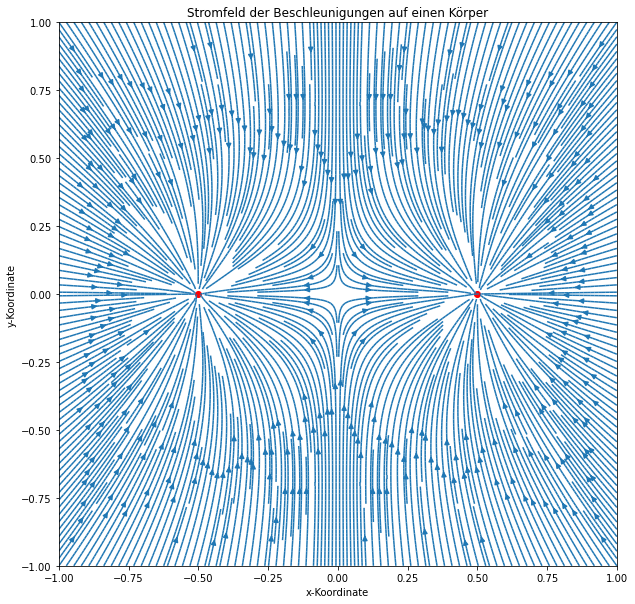

In [ ]:
# Ändern der Plot-Größe
plt.rcParams["figure.figsize"] = (10,10)
# Erstellen eines Plots
fig, ax = plt.subplots()
# Darstellen in einem Streamplot
ax.streamplot(X, Y, U, V, density=5)
# Darstellen der fixierten Positionen
ax.scatter([startPositions[0][0],startPositions[1][0]],[startPositions[0][1],startPositions[1][1]],color='r')
# Beschriften der Achsen
ax.set_ylabel('y-Koordinate')
ax.set_xlabel('x-Koordinate')
ax.set_title('Stromfeld der Beschleunigungen auf einen Körper')
plt.show()
# Sichern der Figur
fig.savefig('vec.pdf')

Ergebnisse:  
<img src="https://drive.google.com/uc?export=view&id=11giMlU02R2woSM-3oO1M3rAM3v456FJD" width="500"/>